In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
from pydantic import parse_obj_as
from typing import List
import gc

import matplotlib.pyplot as plt
import seaborn as sns
import mlflow

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sales_forecasting.api.model import RequestSchema
from sales_forecasting.utils.feature_engineering import calendar_features, incomplete_data_stores
from sales_forecasting.utils.ml import  results_df, results_keeper, final_results_keeper, prediction_metrics_and_result_keeper, smape, error, store_train_test_selection, model_selection_specific_store, train_test_validate_split_on_date, predicted_vs_real_plot
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [4]:
models=[]
daily_smape=[]
weekly_smape=[]
monthly_smape=[]
percentage_error_model=[]
list_of_incomplete_stores=[]
store=[]


In [5]:
raw_sales_data = pd.read_csv('../data/sales_per_store_per_day.csv', 
    dtype={'Store':'Int64','DayOfWeek':'Int64','Sales':'Int64','Customers':'Int64','Open':'Int64','Promo':'Int64','StateHoliday':'str','SchoolHoliday':'Int64'}, parse_dates=['Date'])

raw_dict=raw_sales_data.to_dict(orient='records')
validated_sales=parse_obj_as(List[RequestSchema], raw_dict)

del raw_sales_data, raw_dict
gc.collect()

sales_df=pd.DataFrame([item.dict() for item in validated_sales])
del validated_sales 
gc.collect()

0

## Feature engineering

In [6]:
sales_df['sales_date'] = pd.to_datetime(sales_df['sales_date'])
sales_df['close_flag'] = np.where(sales_df['open_flag'] == 1, 0, 1)
sales_df['state_holiday_flag']=np.where(sales_df['state_holiday'] == '0', 0, 1)
sales_df = calendar_features(sales_df)
sales_df['week_of_year'] = sales_df['week_of_year'].astype(int)

In [7]:
sales_df

,sales_date,store,sales,customers,open_flag,promo,day_of_week,state_holiday,school_holiday,close_flag,state_holiday_flag,year,month,day_of_month,day_of_year,week_of_year,odd_weeks
0,2015-06-30,1,5735,568,1,1,2,0,0,0,0,2015,6,30,181,27,1
1,2015-06-30,2,9863,877,1,1,2,0,0,0,0,2015,6,30,181,27,1
2,2015-06-30,3,13261,1072,1,1,2,0,1,0,0,2015,6,30,181,27,1
3,2015-06-30,4,13106,1488,1,1,2,0,0,0,0,2015,6,30,181,27,1
4,2015-06-30,5,6635,645,1,1,2,0,0,0,0,2015,6,30,181,27,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
982639,2013-01-01,1111,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982640,2013-01-01,1112,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982641,2013-01-01,1113,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1
982642,2013-01-01,1114,0,0,0,0,2,a,1,1,1,2013,1,1,1,1,1


### Explore Machine Learning models on one store

In [8]:
one_store = sales_df[sales_df['store']==85].copy()
x_train, y_train, x_test, y_test, x_validate, y_validate = train_test_validate_split_on_date(one_store.drop(columns=['store','customers','state_holiday']), datetime(2015,3,1), datetime(2015,5,1), datetime_col='sales_date', output_col='sales')

## LGBMRegressor

Total value of sales on test predicted interval: 462814
Absolute error:  64513
Percentage error reported to real sales: 3.15%
Daily SMAPE is: 13.45 %
Weekly SMAPE is: 7.31 %
Monthly SMAPE is: 9.0 %


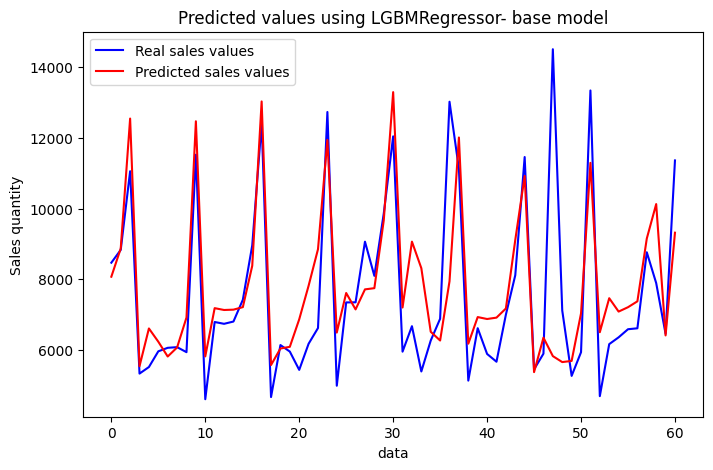

In [9]:
EXPERIMENT_NAME = "sales_forecasting"
EXPERIMENT_ID = mlflow.create_experiment(EXPERIMENT_NAME)
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='base_model') as run:
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    predicted_vs_real_plot(y_test, y_pred_lgb, title='Predicted values using LGBMRegressor- base model', image_name='real_vs_predicted')
    
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.lightgbm.log_model(model, 'model')
    mlflow.log_artifact("real_vs_predicted.png")

## Hyperparameter optimization using Optuna

In [10]:
import optuna
from sklearn.metrics import mean_squared_error

def objective_lgbm(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    param = {
        'metric': 'rmse', 
        'random_state': 1,
        'objective':'regression',
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 50.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 50.0),
        'colsample_bytree': trial.suggest_loguniform("colsample_bytree", 0.1, 1.0),
        'subsample': trial.suggest_loguniform("subsample", 0.1, 1.0),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1.0),
        'max_depth': trial.suggest_int("max_depth", 1, 20),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 20),
        'min_child_samples': trial.suggest_int('min_child_samples',3, 300)
    }
    model = LGBMRegressor(**param)  
    model.fit(x_train,y_train,eval_set=[(x_validate,y_validate)],early_stopping_rounds=100,verbose=False)
    preds = model.predict(x_validate)
    rmse = mean_squared_error(y_validate, preds,squared=False)
    
    return rmse
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=200)
print('Number of finished trials:', len(study_lgbm.trials))
print('Best trial:', study_lgbm.best_trial.params)
best_lgbm_params=study_lgbm.best_params

[I 2023-05-12 20:43:12,596] A new study created in memory with name: no-name-8f43eb98-06e0-464d-a72c-f536965629e9
[I 2023-05-12 20:43:12,692] Trial 0 finished with value: 2451.828797088421 and parameters: {'n_estimators': 593, 'reg_alpha': 0.01070259706691725, 'reg_lambda': 0.38512998418134553, 'colsample_bytree': 0.7323346452232987, 'subsample': 0.10427303941166613, 'learning_rate': 5.881021232932179e-06, 'max_depth': 9, 'num_leaves': 3, 'min_child_samples': 194}. Best is trial 0 with value: 2451.828797088421.
[I 2023-05-12 20:43:12,747] Trial 1 finished with value: 2451.4482174581026 and parameters: {'n_estimators': 300, 'reg_alpha': 0.002476209296470854, 'reg_lambda': 0.006258258110596922, 'colsample_bytree': 0.6463224805088215, 'subsample': 0.7946149961807253, 'learning_rate': 2.0737075934023183e-05, 'max_depth': 3, 'num_leaves': 17, 'min_child_samples': 189}. Best is trial 1 with value: 2451.4482174581026.
[I 2023-05-12 20:43:12,963] Trial 2 finished with value: 1399.8968123935788

Number of finished trials: 200
Best trial: {'n_estimators': 585, 'reg_alpha': 16.410197317308253, 'reg_lambda': 4.47491137229999, 'colsample_bytree': 0.8638451273588836, 'subsample': 0.12049307605917312, 'learning_rate': 0.98150284480358, 'max_depth': 20, 'num_leaves': 8, 'min_child_samples': 18}


Total value of sales on test predicted interval: 462814
Absolute error:  64556
Percentage error reported to real sales: 11.09%
Daily SMAPE is: 14.04 %
Weekly SMAPE is: 11.23 %
Monthly SMAPE is: 10.13 %


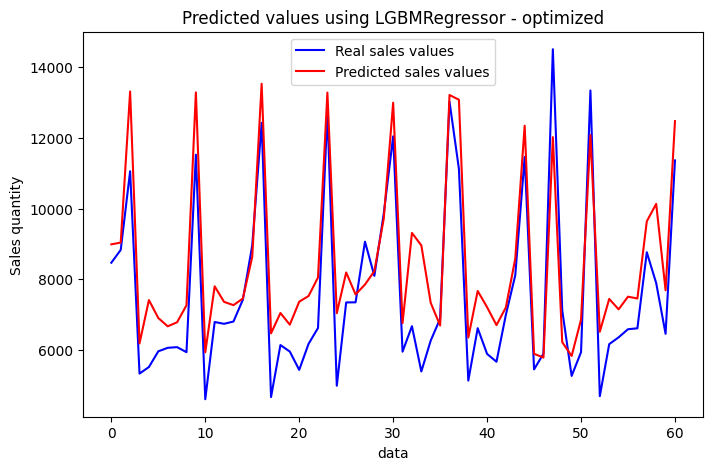

In [11]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimized_lgbm') as run:
    RUN_ID = run.info.run_id
    model = LGBMRegressor()
    model.set_params(**best_lgbm_params)
    model = model.fit(x_train, y_train)
    y_pred_lgb = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_lgb, model)
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.lightgbm.log_model(model, 'model')

    predicted_vs_real_plot(y_test, y_pred_lgb, title='Predicted values using LGBMRegressor - optimized', image_name='real_vs_predicted_lgbm_final')
    mlflow.log_artifact("real_vs_predicted_lgbm_final.png")

## RandomForestRegressor

In [12]:
def objective_rf(trial,x_train=x_train,y_train=y_train,x_test=x_test,y_test=y_test):
    
    param = {
        'random_state': 1,
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'min_samples_leaf' : trial.suggest_int('min_samples_leaf', 2, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 8),
        'max_features': trial.suggest_int('max_features', 1, 12)
    }
    model = RandomForestRegressor(**param)  
    model.fit(x_train,y_train)
    preds = model.predict(x_validate)
    rmse = mean_squared_error(y_validate, preds, squared=False)
    
    return rmse
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=200)
print('Number of finished trials:', len(study_rf.trials))
print('Best trial:', study_rf.best_trial.params)
best_rf_params=study_rf.best_params

[I 2023-05-12 20:44:04,489] A new study created in memory with name: no-name-1f0bfecf-58c9-4025-a391-fc1e35334958
[I 2023-05-12 20:44:05,669] Trial 0 finished with value: 1418.9870436109506 and parameters: {'n_estimators': 642, 'max_depth': 9, 'min_samples_leaf': 15, 'min_samples_split': 3, 'max_features': 10}. Best is trial 0 with value: 1418.9870436109506.
[I 2023-05-12 20:44:06,044] Trial 1 finished with value: 1407.5567220078538 and parameters: {'n_estimators': 218, 'max_depth': 7, 'min_samples_leaf': 13, 'min_samples_split': 4, 'max_features': 6}. Best is trial 1 with value: 1407.5567220078538.
[I 2023-05-12 20:44:06,986] Trial 2 finished with value: 1835.3641800323173 and parameters: {'n_estimators': 676, 'max_depth': 16, 'min_samples_leaf': 16, 'min_samples_split': 4, 'max_features': 2}. Best is trial 1 with value: 1407.5567220078538.
[I 2023-05-12 20:44:07,344] Trial 3 finished with value: 1800.5863487100262 and parameters: {'n_estimators': 294, 'max_depth': 2, 'min_samples_lea

Number of finished trials: 200
Best trial: {'n_estimators': 430, 'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4, 'max_features': 12}


Total value of sales on test predicted interval: 462814
Absolute error:  36886
Percentage error reported to real sales: 1.48%
Daily SMAPE is: 7.95 %
Weekly SMAPE is: 4.43 %
Monthly SMAPE is: 2.35 %


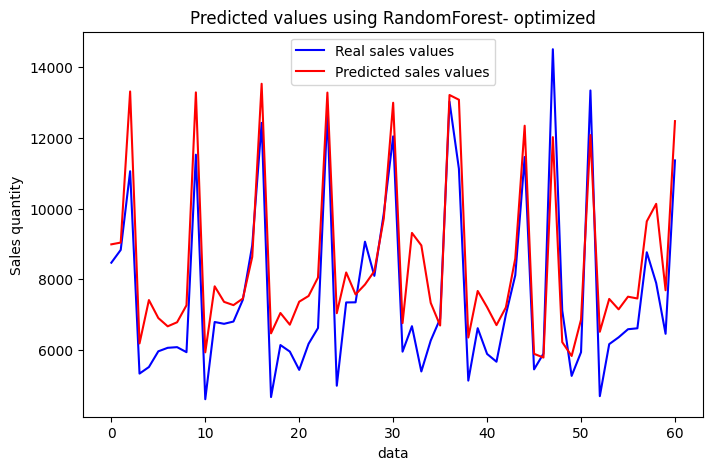

In [13]:
with mlflow.start_run(experiment_id=EXPERIMENT_ID, run_name='optimized_rf') as run:
    # Retrieve run id
    RUN_ID = run.info.run_id
    model = RandomForestRegressor(**best_rf_params)
    model = model.fit(x_train, y_train)
    y_pred_rf = model.predict(x_test)
    models, daily_smape, weekly_smape, monthly_smape, percentage_error_model=prediction_metrics_and_result_keeper(y_test, y_pred_rf, model)
    mlflow.log_metric('daily_smape', daily_smape[-1])
    mlflow.log_metric('weekly_smape', weekly_smape[-1])
    mlflow.log_metric('monthly_smape', monthly_smape[-1])
    mlflow.sklearn.log_model(model, 'model')

    plt.figure(figsize=(8,5))  
    plt.plot(y_test.values, color='blue', label='Real sales values')  
    plt.plot(y_pred_lgb , color='red', label='Predicted sales values')  
    plt.title('Predicted values using RandomForest- optimized')  
    plt.xlabel('data')  
    plt.ylabel('Sales quantity')  
    plt.legend()
    plt.savefig("real_vs_predicted.png")  
    plt.show()
    mlflow.log_artifact("real_vs_predicted.png")

## Comparative results

In [14]:
# create a model selection dataframe for best model determination
models[0] = 'LGBMRegressor - base'
model_selection = pd.DataFrame({'Model': models, 'daily_smape': daily_smape, 'weekly_smape': weekly_smape, 'monthly_smape' :monthly_smape, 'percentage_error': percentage_error_model})
model_selection.sort_values(by=['daily_smape'], ascending=False, inplace=True)
cmg = sns.light_palette("green", as_cmap=True)
model_selection.style.set_caption('Model Selection').background_gradient(cmap=cmg.reversed())

,Model,daily_smape,weekly_smape,monthly_smape,percentage_error
1,LGBMRegressor,14.040000,11.230000,10.130000,11.090000
0,LGBMRegressor - base,13.450000,7.310000,9.000000,3.150000
2,RandomForestRegressor,7.950000,4.430000,2.350000,1.480000
